In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import networkx as nx
import gym
import optical_rl_gym
import matplotlib.pyplot as plt

 Optical RL Gym Environment for RMSA:

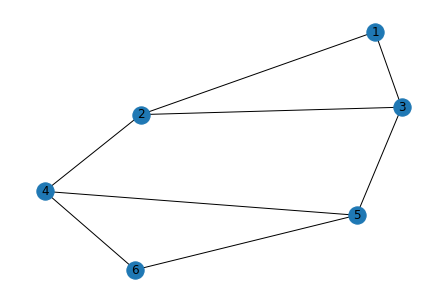

In [2]:
#Using networkx to define a topology

nodes = [1,2,3,4,5,6]
G = nx.Graph()
for i in nodes:
    G.add_node(i)
G.add_edge(1,2,weight = 200) #the weights represent the distance between the two nodes in km here.
G.add_edge(1,3,weight = 500)
G.add_edge(2,3,weight = 600)
G.add_edge(2,4,weight = 700)
G.add_edge(2,3,weight = 600)
G.add_edge(3,5,weight = 300)
G.add_edge(4,5,weight = 200)
G.add_edge(4,6,weight = 400)
G.add_edge(5,6,weight = 500)
nx.draw(G, with_labels =True )

TOPOLOGY FROM EXAMPLE

In [2]:
topology_name = 'nsfnet_chen_eon'
k_paths = 5
#Deep RMSA Implementation
with open('/Users/sudarshanbuxy/Desktop/optical-rl-gym/examples/topologies/nsfnet_chen_eon_5-paths.h5', 'rb') as f:
    topology = pickle.load(f)


<class 'networkx.classes.graph.Graph'>


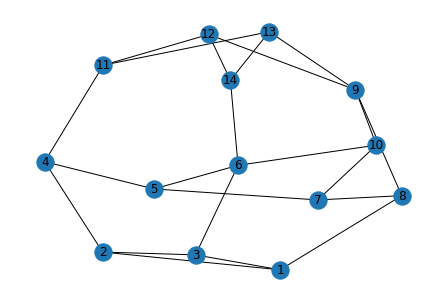

In [3]:
print(type(topology))
nx.draw(topology, with_labels =True )

In [4]:

#defining environment arguments
env_args = dict(topology= topology, seed = 10, episode_length = 100, allow_rejection = False, load = 50 )
#allow rejection parameter is used for the agent to proactively reject a connection request.

env = gym.make('RMSA-v0', **env_args)

In [5]:
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Dict(current_service:Discrete(10), topology:Discrete(10))
MultiDiscrete([  5 100])
(-inf, inf)


In [6]:
node_request_probabilites = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])
env2_args = dict(topology = topology, seed = 10, allow_rejection = False, 

            j = 1, #allocation of first suitable spectrum block according to the DeepRMSA)
            mean_service_holding_time = 7.5, #mean service holding time
            episode_length = 100, node_request_probabilities = node_request_probabilites)
env2 = gym.make('DeepRMSA-v0', **env2_args)


In [8]:

print(env2.action_space)
print(env2.observation_space)
print(env2.reward_range)

Discrete(5)
Box([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], (54,), uint8)
(-inf, inf)


In [9]:
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from IPython.display import clear_output


Defining a callback function so we can save the model which gave the last best results after we check if the performance has improved every check_freq number of steps.

In [10]:

# callback from https://stable-baselines.readthedocs.io/en/master/guide/examples.html#using-callback-monitoring-training
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps), end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

In [11]:
log_dir = "./tmp/deeprmsa-ppo/"
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)

Using PPO on DeepRMSA Environment:

In [12]:
env2 = Monitor(env2, log_dir+ 'training', info_keywords=('episode_service_blocking_rate', 'episode_bit_rate_blocking_rate'))
#currently trying out DeepRMSA environment out for PPO policy.
policy_args = dict(net_arch = 5*[128])
agent = stable_baselines3.PPO('MlpPolicy',env2, policy_kwargs = policy_args, verbose = 0, gamma = 0.95, learning_rate= 10e-5)
#a = agent.learn(total_timesteps=50000, callback=callback)

In [13]:
total_timesteps = 50000
service_blocking_rates = []
bit_rate_blocking_rates = []
service_requests = []
bit_rate_requests = []
for timestep in range(total_timesteps):
    env2.reset()
    obs, reward, done, info = env2.step(agent.action_space.sample())
    service_blocking_rates.append(info['service_blocking_rate'])
    bit_rate_blocking_rates.append(info['bit_rate_blocking_rate'])
    service_requests.append(info['service requests'])
    bit_rate_requests.append(info['bitrate requests'])
    #env2.render()
    if done:
        break

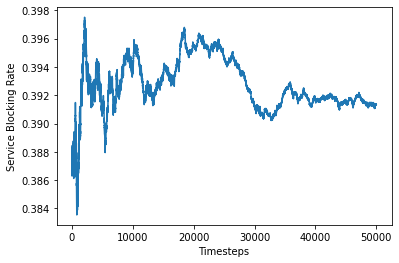

In [31]:
plt.xlabel('Timesteps')
plt.ylabel('Service Blocking Rate')
plt.plot(service_blocking_rates)
plt.show()

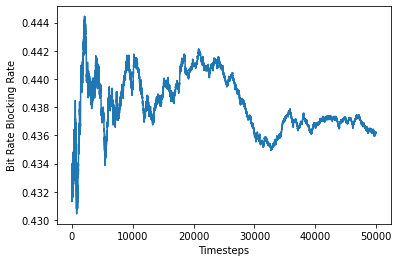

In [32]:
plt.xlabel('Timesteps')
plt.ylabel('Bit Rate Blocking Rate')
plt.plot(bit_rate_blocking_rates)
plt.show()

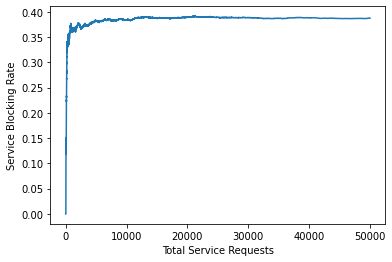

In [19]:
plt.xlabel('Total Service Requests')
plt.ylabel('Service Blocking Rate')

plt.plot(service_requests,service_blocking_rates)
plt.show()

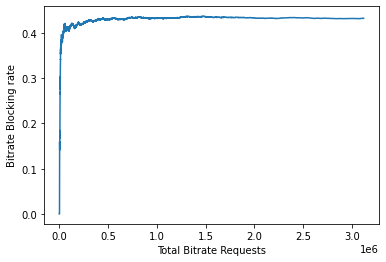

In [20]:
plt.xlabel('Total Bitrate Requests')
plt.ylabel('Bitrate Blocking rate')
plt.plot(bit_rate_requests, bit_rate_blocking_rates)
plt.show()

In [19]:
print(len(service_blocking_rates))
print(len(bit_rate_blocking_rates))

50000
50000


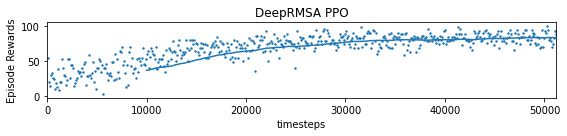

In [13]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DeepRMSA PPO")

In [25]:
(log_dir+ 'training')

./tmp/deeprmsa-ppo/training


In [14]:
env2.reset()

array([ 0.96      ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        , -0.86      ,
       -0.375     , -0.71428571, -0.12      ,  0.        , -0.32      ,
        0.        , -0.71428571, -0.08      ,  0.91666667,  0.02      ,
       -0.125     , -0.14285714, -0.52      , -0.14285714,  0.02      ,
       -0.125     , -0.14285714, -0.5       , -0.21875   , -1.        ,
       -1.        ,  1.        , -0.36      ,  0.33333333])

Using DQN on DeepRMSA environment:

In [35]:
log_dir2 = "./tmp/deeprmsa-dqn/"
os.makedirs(log_dir2, exist_ok=True)
callback2 = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir2)
env2 = Monitor(env2, log_dir2+ 'training', info_keywords=('episode_service_blocking_rate', 'episode_bit_rate_blocking_rate'))

In [21]:
from stable_baselines3 import DQN
policy_args = dict(net_arch = 5*[128])        
#implementing a general network architecture right now, need to change this to the network architecture specified in the DeepRMSA paper.
agent2 = stable_baselines3.DQN('MlpPolicy',env2, policy_kwargs = policy_args, verbose = 1, gamma = 0.95, learning_rate= 10e-5)
#a2 = agent2.learn(total_timesteps=50000, callback=callback2)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [22]:
total_timesteps = 50000
service_blocking_rates2 = []
bit_rate_blocking_rates2 = []
service_requests2 = []
bit_rate_requests2 = []
for i in range(total_timesteps):
    env2.reset()
    obs, reward, done, info = env2.step(agent2.action_space.sample())
    service_blocking_rates2.append(info['service_blocking_rate'])
    bit_rate_blocking_rates2.append(info['bit_rate_blocking_rate'])
    service_requests2.append(info['service requests'])
    bit_rate_requests2.append(info['bitrate requests'])
    #env2.render()
    if done:
        break

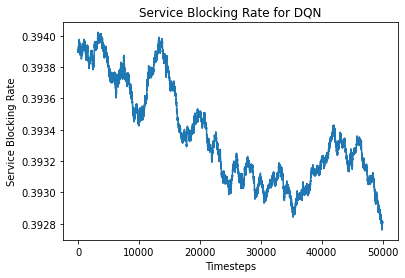

In [42]:
plt.xlabel('Timesteps')
plt.ylabel('Service Blocking Rate')
plt.title("Service Blocking Rate for DQN")
plt.plot(service_blocking_rates2)
plt.show()

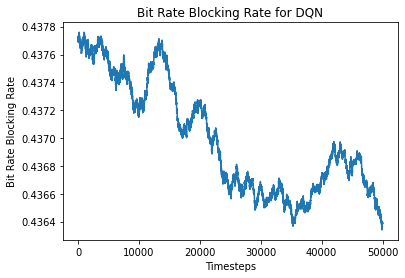

In [43]:
plt.xlabel('Timesteps')
plt.ylabel('Bit Rate Blocking Rate')
plt.title("Bit Rate Blocking Rate for DQN")
plt.plot(bit_rate_blocking_rates2)
plt.show()

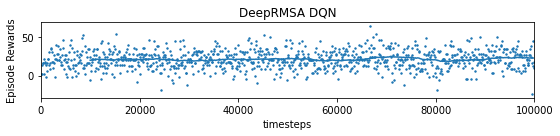

In [39]:
results_plotter.plot_results([log_dir2], 1e5, results_plotter.X_TIMESTEPS, "DeepRMSA DQN")

Using Advantage Actor-Critic (A2C) Method in DeepRMSA Environment:

In [ ]:
log_dir3 = "./tmp/deeprmsa-a2c/"
os.makedirs(log_dir3, exist_ok=True)
callback3 = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir3)
env2 = Monitor(env2, log_dir3+ 'training', info_keywords=('episode_service_blocking_rate', 'episode_bit_rate_blocking_rate'))

In [24]:
agent3 = stable_baselines3.A2C('MlpPolicy',env2, policy_kwargs = policy_args,verbose = 0, gamma = 0.95, learning_rate= 10e-5)
#a3 = agent3.learn(total_timesteps=50000, callback=callback3)

In [25]:
service_blocking_rates3 = []
bit_rate_blocking_rates3 = []
service_requests3 = []
bit_rate_requests3 = []
for timestep in range(total_timesteps):
    env2.reset()
    obs, reward, done, info = env2.step(agent3.action_space.sample())
    service_blocking_rates3.append(info['service_blocking_rate'])
    bit_rate_blocking_rates3.append(info['bit_rate_blocking_rate'])
    service_requests3.append(info['service requests'])
    bit_rate_requests3.append(info['bitrate requests'])
    #env2.render()
    if done:
        break

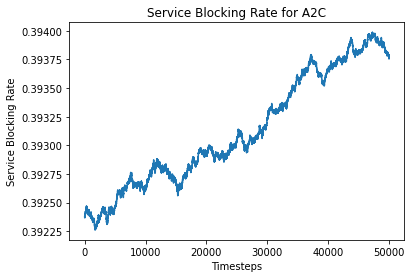

In [49]:
plt.xlabel('Timesteps')
plt.ylabel('Service Blocking Rate')
plt.title("Service Blocking Rate for A2C")
plt.plot(service_blocking_rates3)
plt.show()

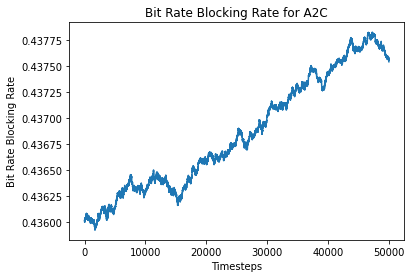

In [48]:
plt.xlabel('Timesteps')
plt.ylabel('Bit Rate Blocking Rate')
plt.title("Bit Rate Blocking Rate for A2C")
plt.plot(bit_rate_blocking_rates3)
plt.show()

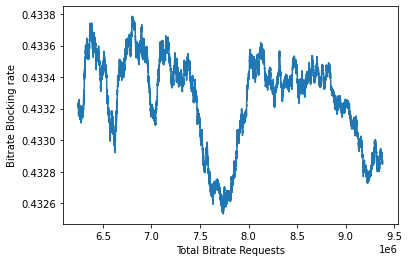

In [26]:
plt.xlabel('Total Bitrate Requests')
plt.ylabel('Bitrate Blocking rate')
plt.plot(bit_rate_requests3, bit_rate_blocking_rates3)
plt.show()

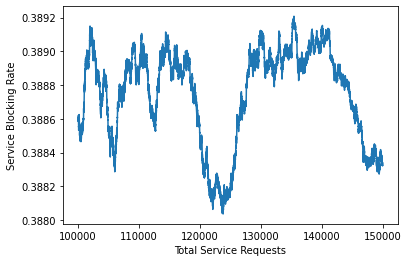

In [27]:
plt.xlabel('Total Service Requests')
plt.ylabel('Service Blocking Rate')

plt.plot(service_requests3,service_blocking_rates3)
plt.show()

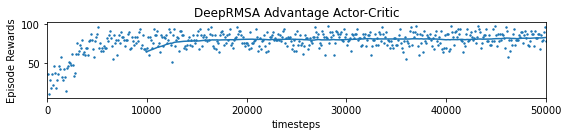

In [ ]:
results_plotter.plot_results([log_dir3], 1e5, results_plotter.X_TIMESTEPS, "DeepRMSA Advantage Actor-Critic")

In [ ]:
env2.reset()

array([ 0.86      ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.32      ,
        0.        ,  0.71428571, -0.12      ,  0.57142857, -0.68      ,
        0.125     ,  0.71428571,  0.62      ,  5.75      , -0.68      ,
        0.        ,  0.71428571,  0.5       ,  8.375     , -1.        ,
       -1.        ,  0.71428571, -0.52      , -0.14285714, -1.        ,
       -1.        ,  0.71428571, -0.88      , -0.7       ])

1. Performance of these three algorithms with variations in parameters. By using the graphs of the different cases we can analyse the following:
i) We measure the performance of the agents with different values of the parameter => To check for which value the agent is performing best i.e. giving best reward.
ii) For the different values of the parameters, we graph the service blocking rates and the bitrate blocking rates. This can help us understand the physical interpretation or impact of parameters on the environment (which is our optical network).
2. By exploring the RMSA environment, we can change the attributes of the network state as well. We can check the current state of the spectrum resources in the network topology in the RMSA environment.
3. Reproducing the results that are mentioned in the Optical Gym Paper for the A2C, DQN, PPO methods for DeepRMSA environment.

I) MEASURING PERFORMANCE OF EACH OF THE AGENTS WITH A CHANGE IN THE LEARNING PARAMETERS USING THE REWARD CURVES

In [ ]:
#5 different values of learning rates for each agent.
#1. PPO
learning_rates = [10e-5, 10e-6, 10e-7, 10e-8, 10e-9]
log_dirs = []
callbacks = []
agents = {{}}
for i in range(5):
    #initialising the log directories and the callback for each learning rate.
    log_dirs.append("./tmp/deeprmsa-ppo-lr" + str(i))
    os.makedirs(log_dirs[i], exist_ok=True)
    #callbacks[i] = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dirs[i])

for i in range(5):
    current_log_dir = log_dirs[i]
    #current_callback = callbacks[i]
    env2 = Monitor(env2, current_log_dir+ 'training', info_keywords=('episode_service_blocking_rate', 'episode_bit_rate_blocking_rate'))
    current_agent = stable_baselines3.PPO('MlpPolicy',env2, policy_kwargs = policy_args,verbose = 0, gamma = 0.95, learning_rate= learning_rates[i])
    agents[i]['service_blocking_rates'] = []
    agents[i]['bit_rate_blocking_rates'] = []
    agents[i]['reward'] = 0
    for j in range(total_timesteps):
        env2.reset()
        obs, reward, done, info = env2.step(current_agent.action_space.sample())
        agents[i]['service_blocking_rates'].append(info['service_blocking_rate'])
        agents[i]['bit_rate_blocking_rates'].append(info['bit_rate_blocking_rate'])
        agents[i]['reward'] += reward
        
        #env2.render()
        
